In [1]:
import praw
import pandas as pd
from urllib.parse import urlparse
from datetime import datetime

reddit = praw.Reddit(
    client_id= '2ST5tRddm-CMj_VlM-5qGw',
    client_secret= 'PmlPHXvIq7lkSyXhckZ_2bg1lA9-7Q',
    user_agent='MyRedditApp/1.0'
)

def get_subreddit(name):
    subreddit = reddit.subreddit(name)
    #gets the info of the subreddit
    subreddit_info = {
        'name': name,
        'subscribers': subreddit.subscribers,
        'created_utc': datetime.utcfromtimestamp(subreddit.created_utc),
        'display_name': subreddit.display_name,
        'title': subreddit.title,
        'public_description': subreddit.public_description,
    }
    
    return subreddit_info

def get_post_data(name, limit=20):
    subreddit = reddit.subreddit(name)
    posts = []
    
    # Get posts
    for post in subreddit.hot(limit=limit):
        post_data = {
            'title': post.title,
            'score': post.score, 
            'Number of Comments': post.num_comments,
            'selftext': post.selftext,
            'Comments': []
        }
        # Gets comments under the post
        post.comments.replace_more(limit=10)
        for comment in post.comments.list():
            comment_data = {
                'body': comment.body,
                'score': comment.score
            }
            post_data['Comments'].append(comment_data)
                
        posts.append(post_data) 
    
    return posts

In [2]:
def analyzeCommunity(subreddit_data, name):
    total_post = len(subreddit_data)
    total_score = sum(post['score'] for post in subreddit_data)
    if total_post > 0:
        avg_score = total_score/total_post
    else:
        avg_score = 0
        
    total_comments = sum(comment['Number of Comments'] for comment in subreddit_data)
    if total_post > 0:
        avg_comments = total_comments/total_post
    else:
        avg_comments = 0
    
    all_comments = []
    for post in subreddit_data:
        all_comments.extend(post['Comments'])
    
    total_comments_score = sum(comment['score'] for comment in all_comments)
    avg_comment_score = total_comments_score/ len(all_comments) if len(all_comments) > 0 else 0
    
    return {
        'subreddit': name,
        'total_posts': total_post,
        'avg_post_score': avg_score,
        'total_comments': total_comments,
        'avg_comments_per_post': avg_comments,
        'total_comments_collected': len(all_comments),
        'avg_comment_score': avg_comment_score
    }
    


In [3]:
python_subreddit = get_post_data('python')
python_subreddit

[{'title': "Sunday Daily Thread: What's everyone working on this week?",
  'score': 2,
  'Number of Comments': 1,
  'selftext': "# Weekly Thread: What's Everyone Working On This Week? 🛠️\n\nHello /r/Python! It's time to share what you've been working on! Whether it's a work-in-progress, a completed masterpiece, or just a rough idea, let us know what you're up to!\n\n## How it Works:\n\n1. **Show & Tell**: Share your current projects, completed works, or future ideas.\n2. **Discuss**: Get feedback, find collaborators, or just chat about your project.\n3. **Inspire**: Your project might inspire someone else, just as you might get inspired here.\n\n## Guidelines:\n\n* Feel free to include as many details as you'd like. Code snippets, screenshots, and links are all welcome.\n* Whether it's your job, your hobby, or your passion project, all Python-related work is welcome here.\n\n## Example Shares:\n\n1. **Machine Learning Model**: Working on a ML model to predict stock prices. Just cracked

In [4]:
python_sub = analyzeCommunity(python_subreddit, 'python')
python_sub

{'subreddit': 'python',
 'total_posts': 20,
 'avg_post_score': 36.75,
 'total_comments': 283,
 'avg_comments_per_post': 14.15,
 'total_comments_collected': 284,
 'avg_comment_score': 8.669014084507042}

In [5]:
nba_subreddit = get_post_data('nba')
nba_subreddit

[{'title': 'Daily Discussion Thread + Game Thread Index',
  'score': 22,
  'Number of Comments': 28,
  'selftext': '# Game Threads Index (May 03, 2025):\n\n|Tip-off|GDT|Away|Score|Home|PGT|\n|:--|:--:|:--|:-:|:--|:--:|\n|07:30 pm ET|[Link](https://www.reddit.com/r/nba/comments/1ke4y9j/game_thread_los_angeles_clippers_33_denver/)|[Los Angeles Clippers](/r/laclippers)|FINAL >!101 to 120!<|[Denver Nuggets](/r/denvernuggets)|[Link](https://www.reddit.com/r/nba/comments/1ke8vqd/post_game_thread_the_denver_nuggets_eliminate_the/)|',
  'Comments': [{'body': 'Would the league benefit more from Clippers/Thunder matchup or Nuggets/Thunder 🤔',
    'score': 6},
   {'body': 'How come the Tatum/Brunson post was removed?', 'score': 3},
   {'body': 'Let’s say one conference every playoff series went to 7 and the other conference every series was 4-0. How much rest would the 4-0 side winner get in between winning their conference and for the finals to start?',
    'score': 3},
   {'body': 'Who do peopl

In [6]:
nba = analyzeCommunity(nba_subreddit, 'nba')
nba

{'subreddit': 'nba',
 'total_posts': 20,
 'avg_post_score': 4445.2,
 'total_comments': 7726,
 'avg_comments_per_post': 386.3,
 'total_comments_collected': 6472,
 'avg_comment_score': 46.85120519159456}

In [7]:
dataScience_subreddit = get_post_data('dataScience')
dataScience_subreddit

[{'title': 'Weekly Entering & Transitioning - Thread 28 Apr, 2025 - 05 May, 2025',
  'score': 9,
  'Number of Comments': 28,
  'selftext': " \n\nWelcome to this week's entering & transitioning thread! This thread is for any questions about getting started, studying, or transitioning into the data science field. Topics include:\n\n* Learning resources (e.g. books, tutorials, videos)\n* Traditional education (e.g. schools, degrees, electives)\n* Alternative education (e.g. online courses, bootcamps)\n* Job search questions (e.g. resumes, applying, career prospects)\n* Elementary questions (e.g. where to start, what next)\n\nWhile you wait for answers from the community, check out the [FAQ](https://www.reddit.com/r/datascience/wiki/frequently-asked-questions) and Resources pages on our wiki. You can also search for answers in [past weekly threads](https://www.reddit.com/r/datascience/search?q=weekly%20thread&restrict_sr=1&sort=new).",
  'Comments': [{'body': "I have recently started looki

In [8]:
ds = analyzeCommunity(dataScience_subreddit, 'dataScience')
ds

{'subreddit': 'dataScience',
 'total_posts': 20,
 'avg_post_score': 151.75,
 'total_comments': 611,
 'avg_comments_per_post': 30.55,
 'total_comments_collected': 603,
 'avg_comment_score': 8.285240464344941}

### Clean up the text so we can train it

In [9]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

all_nba_comments = []
for post in nba_subreddit:
    for comment in post['Comments']:
        all_nba_comments.append(comment['body'])

cleaned_nba_comments = [preprocess_text(comment) for comment in all_nba_comments]
cleaned_nba_comments

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1028)>


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/alexg/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.13/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def extract_topics(subreddit_data, n_topics=5):
    # Combine post titles and text
    texts = []
    for post in subreddit_data:
        combined_text = post['title'] + ' ' + post['selftext']
        texts.append(preprocess_text(combined_text))
    
    # Add comments
    for post in subreddit_data:
        for comment in post['Comments']:
            texts.append(preprocess_text(comment['body']))
    
    # Create document-term matrix
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000)
    dtm = vectorizer.fit_transform(texts)
    
    # Fit LDA model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(dtm)
    
    # Get feature names
    feature_names = vectorizer.get_feature_names_out()
    
    # Extract top words for each topic
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-10 - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
    
    return topics

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer


def analyze_sentiment(subreddit_data):
    sia = SentimentIntensityAnalyzer()
    
    # Analyze post sentiments
    post_sentiments = []
    for post in subreddit_data:
        combined_text = post['title'] + ' ' + post['selftext']
        sentiment = sia.polarity_scores(combined_text)
        post_sentiments.append(sentiment)
    
    # Analyze comment sentiments
    comment_sentiments = []
    for post in subreddit_data:
        for comment in post['Comments']:
            sentiment = sia.polarity_scores(comment['body'])
            comment_sentiments.append(sentiment)
    
    # Calculate average sentiments
    avg_post_sentiment = {
        'compound': sum(s['compound'] for s in post_sentiments) / len(post_sentiments) if post_sentiments else 0,
        'pos': sum(s['pos'] for s in post_sentiments) / len(post_sentiments) if post_sentiments else 0,
        'neu': sum(s['neu'] for s in post_sentiments) / len(post_sentiments) if post_sentiments else 0,
        'neg': sum(s['neg'] for s in post_sentiments) / len(post_sentiments) if post_sentiments else 0
    }
    
    avg_comment_sentiment = {
        'compound': sum(s['compound'] for s in comment_sentiments) / len(comment_sentiments) if comment_sentiments else 0,
        'pos': sum(s['pos'] for s in comment_sentiments) / len(comment_sentiments) if comment_sentiments else 0,
        'neu': sum(s['neu'] for s in comment_sentiments) / len(comment_sentiments) if comment_sentiments else 0,
        'neg': sum(s['neg'] for s in comment_sentiments) / len(comment_sentiments) if comment_sentiments else 0
    }
    
    return {
        'post_sentiment': avg_post_sentiment,
        'comment_sentiment': avg_comment_sentiment
    }

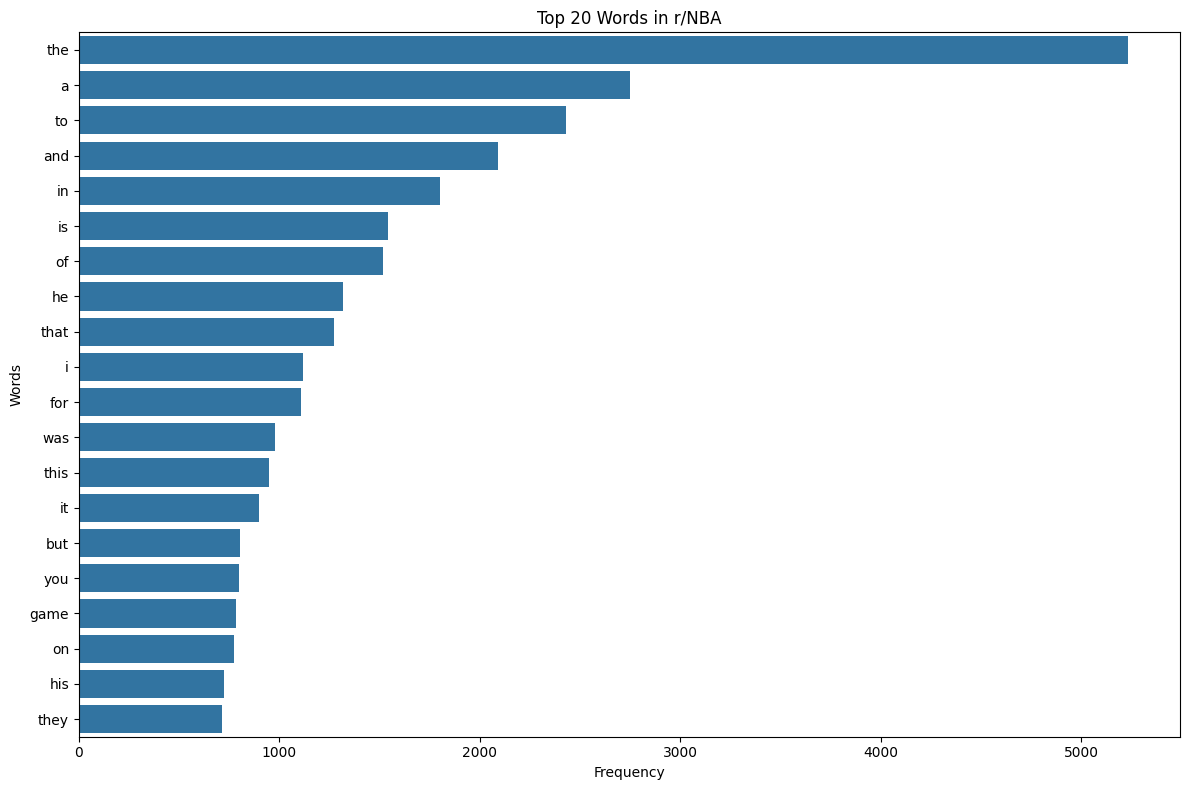

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_word_frequency(subreddit_data, top_n=20):
    all_text = ''.join(subreddit_data)
    preprocessed_text = preprocess_text(all_text)
    
    words = preprocessed_text.split()
    word_counts = Counter(words)

    top_words = word_counts.most_common(top_n)
    
    return top_words

def plot_word_frequency(top_words, subreddit_name):
    words, counts = zip(*top_words)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f'Top {len(words)} Words in r/{subreddit_name}')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    
    return plt

nba_top_words = analyze_word_frequency(cleaned_nba_comments)
nba_plot = plot_word_frequency(nba_top_words, "NBA")
plt.show()

In [ ]:
analyze_word_frequency(nba_subreddit, 20)